In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cross_validation import KFold
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle







/Users/MichaelQu/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


1) Load in the dataset https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv into a pandas dataframe



In [2]:
df = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv', index_col=0)
df.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


2) Convert default and student to categorical variables.



In [3]:
df['default'] = df['default'].map({'Yes': 1, 'No': 0})
df['student'] = df['student'].map({'Yes': 1, 'No': 0})

df.head()

,default,student,balance,income
1,0,0,729.526495,44361.625074
2,0,1,817.180407,12106.134700
3,0,0,1073.549164,31767.138947
4,0,0,529.250605,35704.493935
5,0,0,785.655883,38463.495879


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color of the outcome of default labeled red if yes and blue if no.



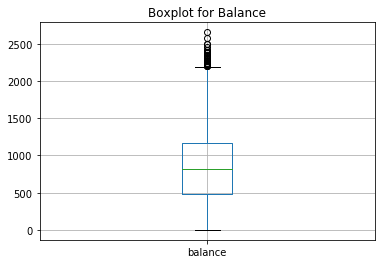

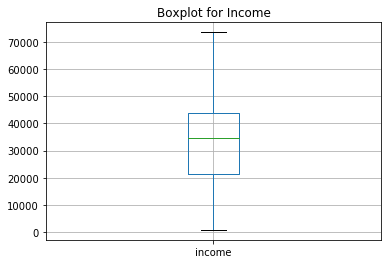

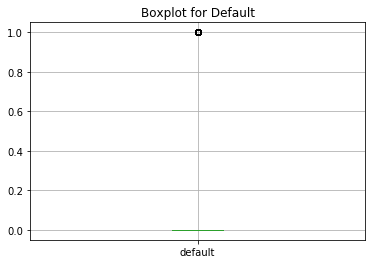

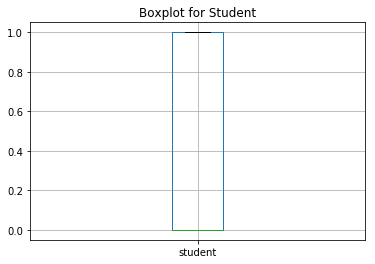

In [4]:
# Boxplots
df.boxplot(column='balance')
plt.title('Boxplot for Balance')
plt.show()

df.boxplot(column='income')
plt.title('Boxplot for Income')
plt.show()

df.boxplot(column='default')
plt.title('Boxplot for Default')
plt.show()

df.boxplot(column='student')
plt.title('Boxplot for Student')
plt.show()


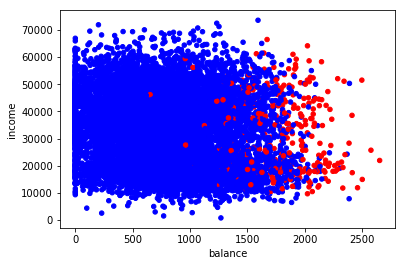

In [5]:
colors = np.where(df['default'] ==1, 'r', 'b')
df.plot(kind='scatter', x='balance', y='income',c=colors)
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley on the balance and income variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.



The accuracy of this test is:  0.945670628183
[   0    1    2 ..., 2597 2598 2599]
[ 352189.88046615  352022.92134881  351855.96223147 ...,  -81402.9472652
  -81569.90638254  -81736.86549988]


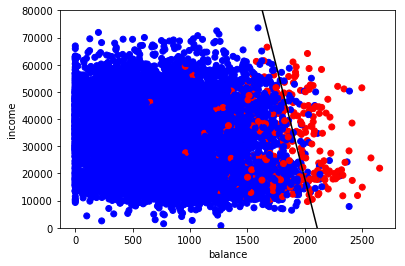

In [6]:
########## Train the model ##########

# Assign X and Y
student_only = df[df['student'] == 1]
X = student_only.loc[: , ['balance','income']]
y = student_only['default']

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Train with training data
clf = LogisticRegression(penalty='l1')
clf.fit(X_train, y_train)

# Predict using test data
predictions = clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print('The accuracy of this test is: ', accuracy)

# Decision Boundary
coef = clf.coef_[0]
b = clf.intercept_
xx = np.arange(0,2600,1)
yy = (b + coef[0] * xx)/(-coef[1])


print(xx)
print(yy)

# Plot the result
plt.scatter(df['balance'], df['income'], c=colors)
plt.plot(xx, yy, 'black')
plt.xlabel('balance')
plt.ylabel('income')
plt.ylim(0,80000)
plt.show()



Area under the ROC curve :  0.90775862069


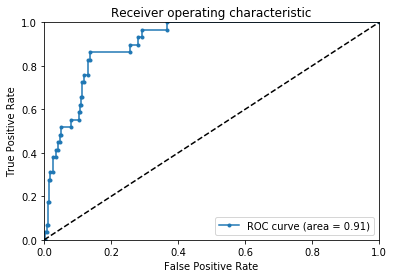

In [7]:
# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    
    # Split into train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print("Area under the ROC curve : ", roc_auc)
    return fpr, tpr, roc_auc, thresholds

def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    

fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,penalty='l1')
generate_ROCplot(fpr,tpr,'LR',roc_auc)


5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking of coefficients. How does performance improve with the added variable?



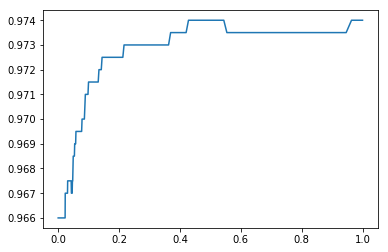

The accuracy of this test is:  0.974
Area under the ROC curve :  0.631835342833


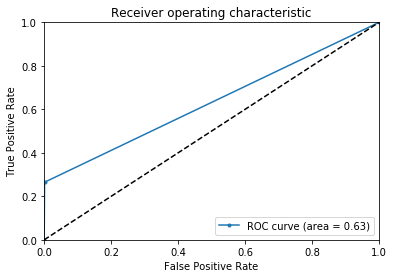

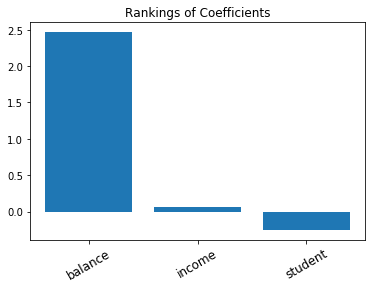

In [8]:
########## Train the model ##########

# Assign X and Y
X = df.loc[: , ['balance','income','student']]
y = df['default']
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Assign alphas
c_values = np.logspace(-8, 0, 1000)
scores = []
    
# Find optimal alpha
for c_value in c_values:
    clf = LogisticRegression(penalty='l2',C=c_value)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

# create a classifier with optimal c value
i_c_optim = np.argmax(scores)
c_optim = c_values[i_c_optim]

plt.plot(c_values,scores)
plt.show()


clf = LogisticRegression(penalty='l2',C=c_optim)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print('The accuracy of this test is: ', accuracy)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : ", roc_auc)

# Plot ROC curve
generate_ROCplot(fpr,tpr,'LR',roc_auc)

# Plot rankings of coefficients
labels = ['balance', 'income', 'student']
index = np.arange(len(labels))
plt.bar(index, clf.coef_[0])
plt.xticks(index, labels, fontsize=12, rotation=30)
plt.title('Rankings of Coefficients')
plt.show()




## Answer 5

It is hard to compare the two regressions because we are doing Lasso for one regression and Ridge for this regression. However, looking at our coefficient weights, we can see that adding a student variable does not impact the default rate prediction that much. In fact, according to our coefficients, balance is the most important coefficient.

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).



In [33]:
X = df.loc[: , ['balance','income','student']]
y = df['default']

logistic_regr_scores = cross_val_score(clf, X, y, cv=5)
print('The scores from cross-validation are: ', logistic_regr_scores)


The scores from cross-validation are:  [ 0.96651674  0.96651674  0.9665      0.96598299  0.96648324]


### Answer 6)

As we can see from the scores above, the model gives good predictions for 5 fold cross-validation. Thus, our model is robust.

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?



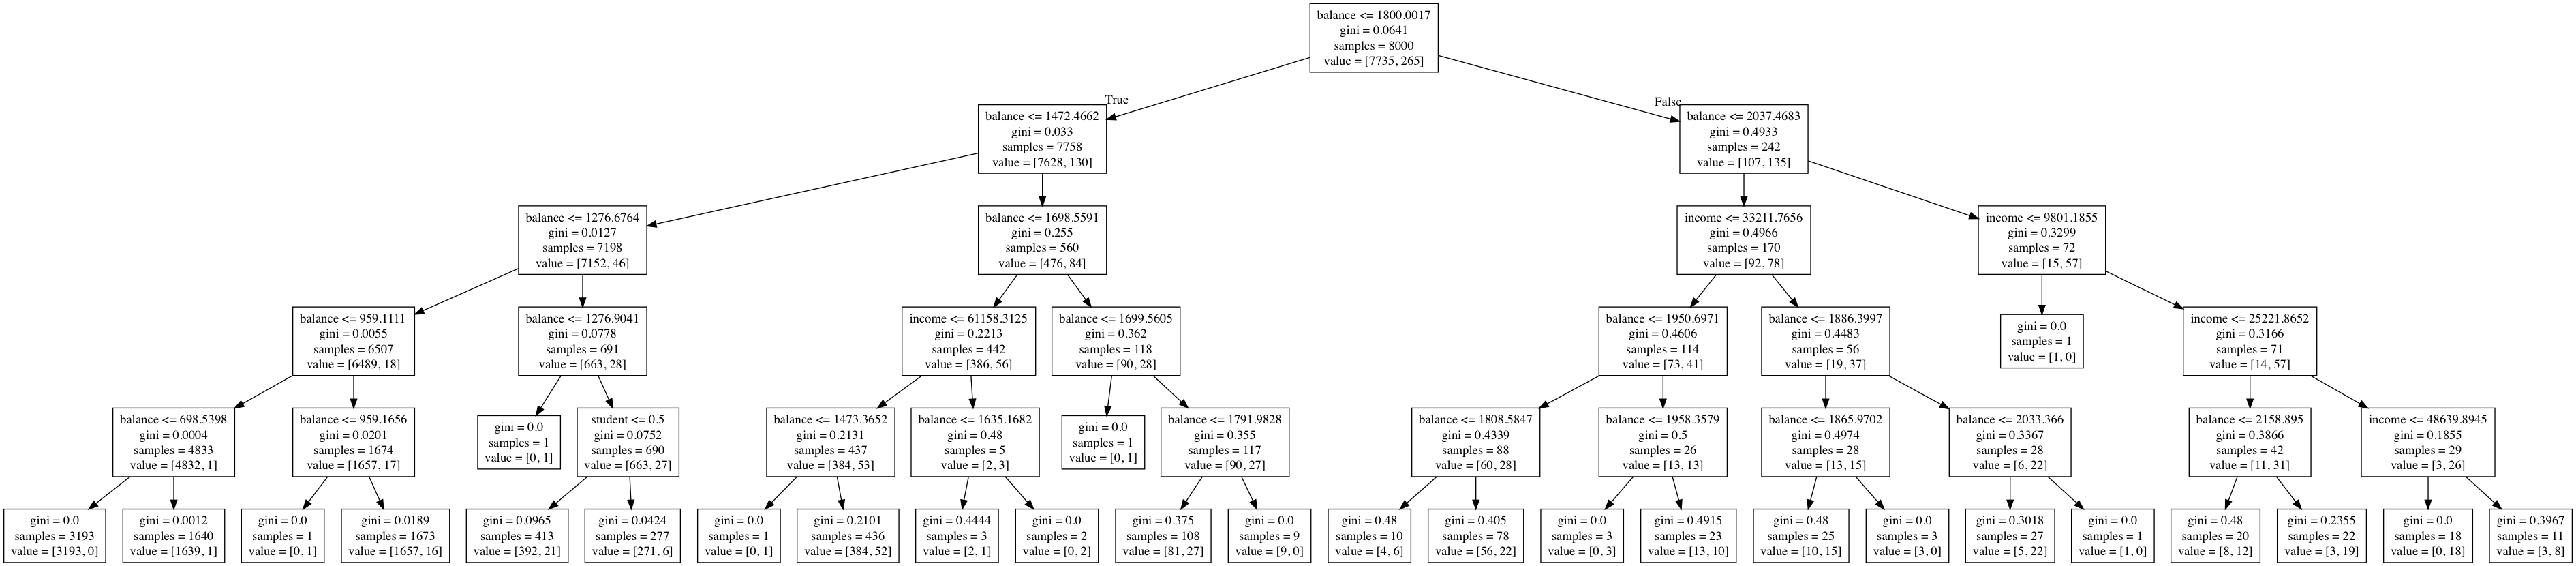

In [32]:

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image
from sklearn.externals.six import StringIO
import seaborn
import pydotplus


# Dataset
X = df.loc[: , ['balance','income','student']]
y = df['default']

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Fit the decision tree
regr = DecisionTreeClassifier(max_depth=5)
regr.fit(X_train,y_train)

# Predict
y_pred = regr.predict(X_test)

dot_data = StringIO()  
export_graphviz(regr, out_file=dot_data, feature_names=X_train.columns)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

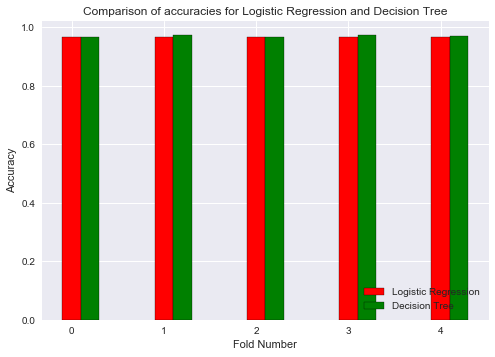

Mean for Decision Trees:  0.970200344175
Mean for Logistic Regression:  0.966399943275
Standard Deviation for Decision Trees:  0.00215389734749
Standard Deviation for Logistic Regression:  0.000208845617591


In [34]:
X = df.loc[: , ['balance','income','student']]
y = df['default']


# plt.figure(figsize = (10, 10))
# ax = plt.subplot(111)

decision_tree_scores = cross_val_score(regr, X, y, cv=5)

# Plot the graph
barWidth = 0.2

r1 = np.arange(len(logistic_regr_scores))
r2 = [x + barWidth for x in r1]

plt.bar(r1, logistic_regr_scores, width = barWidth, color = 'red', edgecolor = 'black', label='Logistic Regression')
plt.bar(r2, decision_tree_scores, width = barWidth, color = 'green', edgecolor = 'black', label='Decision Tree')
plt.legend(loc=4)
plt.title('Comparison of accuracies for Logistic Regression and Decision Tree')
plt.ylabel('Accuracy')
plt.xlabel('Fold Number')
plt.show()

print('Mean for Decision Trees: ', decision_tree_scores.mean())
print('Mean for Logistic Regression: ', logistic_regr_scores.mean())
print('Standard Deviation for Decision Trees: ', decision_tree_scores.std())
print('Standard Deviation for Logistic Regression: ', logistic_regr_scores.std())




### Answer 7)

It seems that overall both are good classifiers. However, the decision tree has a higher mean accuracy while the logistic regression has a smaller standard deviation for it's accuracies.

8) Find the optimal decision tree depth and compute the AUC ROC.



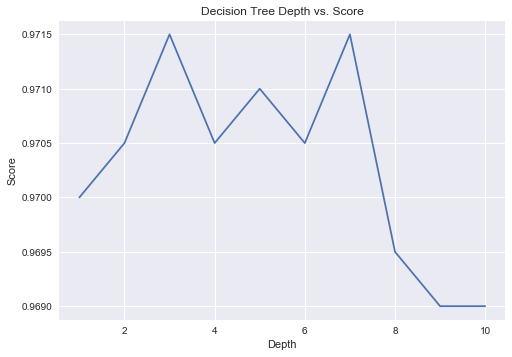

In [66]:
# Find optimal decision tree depth
X = df.loc[: , ['balance','income','student']]
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Iterate through different depths
depths = range(1,11)
scores = []
for depth in depths:    
    regr = DecisionTreeClassifier(max_depth=depth)
    regr.fit(X_train, y_train)
    scores.append(regr.score(X_test, y_test))

# Plot graph of different depths
plt.plot(depths, scores)
plt.title('Decision Tree Depth vs. Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.show()
    

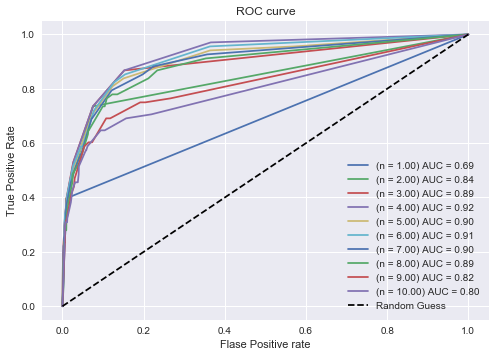

In [68]:
# Compute AUC ROC

# Dataset
X = df.loc[: , ['balance','income','student']]
y = df['default']


depths = range(1,11)
for n in depths:
    # Split into train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
    
    # Fit the decision tree
    tree = DecisionTreeClassifier(max_depth = n)
    tree.fit(X_train, y_train)
    predictions = tree.predict_proba(X_test)
    
    # Calculate AUC ROC
    fpr, tpr, _ = roc_curve(y_test, predictions[:,1])
    roc_auc = auc(fpr, tpr)
    
    # Plot
    plt.plot(fpr, tpr, label = '(n = %.2f) AUC = %.2f'%(n, roc_auc))
    plt.xlabel('Flase Positive rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc=4)
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label = 'Random Guess')
plt.legend(loc=4)
plt.show()


### Answer 8)

From the graphs above, we can see that there is no clear answer to what is the best depth. It seems that depths 3 to 7 are all pretty good. Looking at the AUC ROC curve, depth = 4 gives us the best AUC ROC curve. Thus, the best ROC curve is somewhere between 3 and 7.